# This notebook is a continuation of the previous notebook. The preprocessing and data analysis steps are the same. We use the same feature extraction methods: Vectorization and TFIDF. 
# We apply these methods to the preprocessed data, and then train a Logistic Regression and XGBoost model on the data. We finish by evaluating the performance of the models using accuracy, precision, recall and F1_score. 
# We chose to use Logistic Regression and XGBoost as they are commonly used for text classification tasks and have shown good performance in various NLP applications. Additionally, we want to see the differences between the Naive Bayes and Random Forest models. 

In [6]:
# Step 1: import the necessary libraries
# Data handling
import pandas as pd
import numpy as np

# Text preprocessing
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Machine learning models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Optional - Visualization
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#Step 2: Reading the data and preliminary analysis

In [7]:
dataframe = pd.read_csv("Dataset_slack/training_data_lowercase.csv", sep='\t', header=None)
dataframe.columns = ['label', 'text']
dataframe.head()

test_data = pd.read_csv("Dataset_slack/testing_data_lowercase_nolabels.csv", sep='\t', header=None)
test_data.columns = ['label', 'text']
test_data.head()

,label,text
0,2,copycat muslim terrorist arrested with assault...
1,2,wow! chicago protester caught on camera admits...
2,2,germany's fdp look to fill schaeuble's big shoes
3,2,mi school sends welcome back packet warning ki...
4,2,u.n. seeks 'massive' aid boost amid rohingya '...


#Preprocessing on data

*   Dropping few columns
*   checking for nulls


Dropping subject and date columns as we don't think these contain relevant information to determine whether news is fake news or not and to prevent untrue correlations. 

In [8]:
df = dataframe.copy()
df_test = test_data.copy()


Checking the class imbalance

In [9]:
df["label"].value_counts() #It seems classes are balanced

label
0    17572
1    16580
Name: count, dtype: int64

Checking for nulls in the dataset

In [10]:
df.isnull().sum() # there is no null value

label    0
text     0
dtype: int64

Step 3: Create a Function for all data cleaning

In [11]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Download the 'punkt_tab' resource
nltk.download('punkt_tab')


def text_preprocessing_pipeline(text):
    # Step 1: Tokenize the text
    tokens = word_tokenize(text)

    # Step 2: Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words]

    # Step 3: Remove punctuation and numbers
    tokens = [re.sub(r'[^a-zA-Z]', '', word) for word in tokens]  # Keep only letters
    tokens = [word for word in tokens if word]  # Remove empty strings

    # Step 4: Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(lemmatized_tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\karel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [12]:
df['clean_text'] = df['text'].apply(text_preprocessing_pipeline)

In [13]:
# Create a new DataFrame with the cleaned text and cleaned titles
cleaned_df = pd.DataFrame({
    'clean_text': df['clean_text'],
    'label': df['label']
})

print(cleaned_df.head())
print(cleaned_df.shape)



                                          clean_text  label
0  donald trump sends embarrassing new year eve m...      0
1  drunk bragging trump staffer started russian c...      0
2  sheriff david clarke becomes internet joke thr...      0
3  trump obsessed even obamas name coded website ...      0
4  pope francis called donald trump christmas speech      0
(34152, 2)


# Train Test Split

In [14]:
#Model 1: CountVectorizer + Losistic Regression
#When we train the model on two columns, a difficulty that arises is that CountVectorizer does not automatically concatenate the two columns as we would want it to. 
# This causes shape mismatches. The solution we implemented is to concatenate the two columns. 

In [15]:
X = cleaned_df['clean_text']  # Features: cleaned text and title, concatenated text and title columns
y = cleaned_df['label']  # 'fake' or 'real'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Model 1: CountVectorizer + Logistic Regression

In [16]:
# Use CounVectorizer to convert text data into a matrix of token counts
cv = CountVectorizer(stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [17]:
# Train and evaluate Logistic regression model with CountVectorizer
LG = LogisticRegression()
LG.fit(X_train_cv, y_train)
pred1 = LG.predict(X_test_cv)

print("Model 1 Accuracy:", accuracy_score(y_test, pred1))


Model 1 Accuracy: 0.9352949787732396


In [18]:
# Create pickle files for the model and vectorizer
import pickle
# Save the model
with open('model1_logistic_regression.pkl', 'wb') as model_file:
    pickle.dump(LG, model_file)
# Save the vectorizer
with open('model1_count_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(cv, vectorizer_file)


In [19]:
confusion_matrix(y_test, pred1)

array([[3274,  255],
       [ 187, 3115]])

In [20]:
LG.score(X_test_cv, y_test)
print("Model 1 Accuracy:", accuracy_score(y_test, pred1))

Model 1 Accuracy: 0.9352949787732396


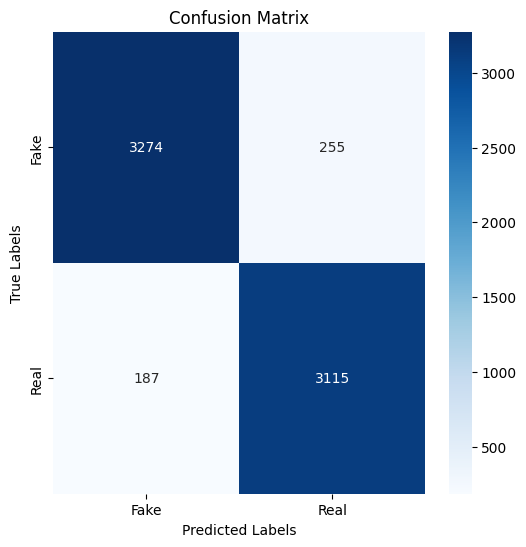

In [21]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, pred1), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
xtricklabels = ['Fake', 'Real']
ytricklabels = ['Fake', 'Real']
plt.xticks(np.arange(2) + 0.5, labels=xtricklabels)
plt.yticks(np.arange(2) + 0.5, labels=ytricklabels) # Add this line to label y-axis
plt.show()

#Model2 TF-IDF + Logistic Regression

In [22]:
# Use TfidfVectorizer to convert text data into a matrix of TF-IDF features
TfidfVectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = TfidfVectorizer.fit_transform(X_train)
X_test_tfidf = TfidfVectorizer.transform(X_test)

In [23]:
# Train and evalaute Logistic Regression model with TfidfVectorizer
LG2 = LogisticRegression()
LG2.fit(X_train_tfidf, y_train)
pred2 = LG2.predict(X_test_tfidf)
print("Model 2 Accuracy:", accuracy_score(y_test, pred2))

Model 2 Accuracy: 0.9307568438003221


In [24]:
confusion_matrix(y_test, pred2)

array([[3259,  270],
       [ 203, 3099]])

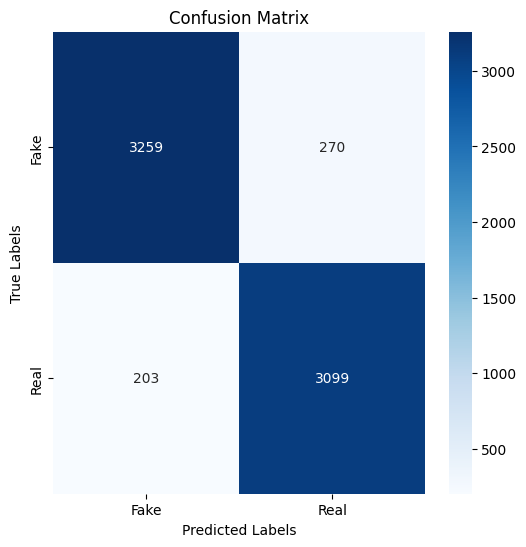

In [25]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, pred2), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
xtricklabels = ['Fake', 'Real']
ytricklabels = ['Fake', 'Real']
plt.xticks(np.arange(2) + 0.5, labels=xtricklabels)
plt.yticks(np.arange(2) + 0.5, labels=ytricklabels) # Add this line to label y-axis
plt.show()



#Model_3 CountVectorizer + XGBoost

In [26]:
# Train and evaluate XGBoost model with CountVectorizer
XGBmodel1 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
XGBmodel1.fit(X_train_cv, y_train)
pred3 = XGBmodel1.predict(X_test_cv)
print("XGBoost Model 3 Accuracy:", accuracy_score(y_test, pred3))




C:\Users\karel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:32:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model 3 Accuracy: 0.8824476650563607


In [27]:
confusion_matrix(y_test, pred3)


array([[2916,  613],
       [ 190, 3112]])

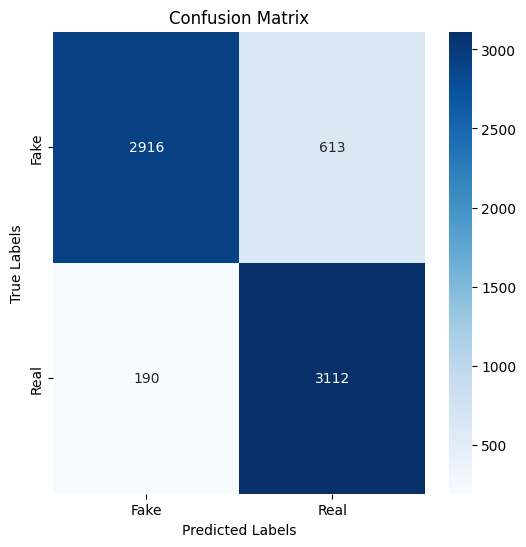

In [28]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, pred3), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
xtricklabels = ['Fake', 'Real']
ytricklabels = ['Fake', 'Real']
plt.xticks(np.arange(2) + 0.5, labels=xtricklabels)
plt.yticks(np.arange(2) + 0.5, labels=ytricklabels) # Add this line to label y-axis
plt.show()


C:\Users\karel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:32:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model 4 Accuracy: 0.8881569316351925


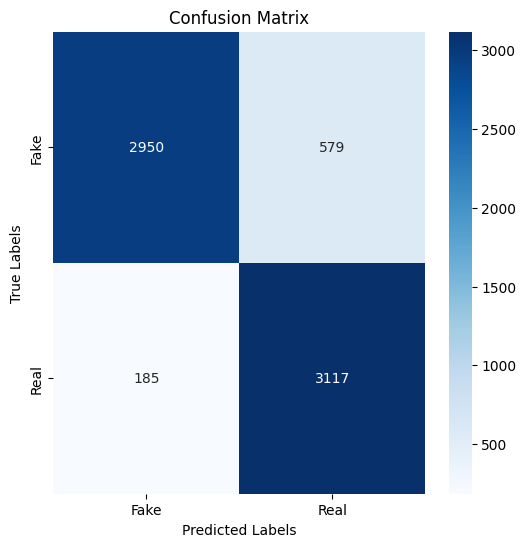

In [29]:
#Model 4: XGBoost with TfidfVectorizer
XGBmodel2 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
XGBmodel2.fit(X_train_tfidf, y_train)
pred4 = XGBmodel2.predict(X_test_tfidf)
print("XGBoost Model 4 Accuracy:", accuracy_score(y_test, pred4))
confusion_matrix(y_test, pred4)
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, pred4), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
xtricklabels = ['Fake', 'Real']
ytricklabels = ['Fake', 'Real']
plt.xticks(np.arange(2) + 0.5, labels=xtricklabels)
plt.yticks(np.arange(2) + 0.5, labels=ytricklabels) # Add this line to label y-axis
plt.show()


In [30]:
#Below we compare the different models based on their accuracy, precision, recall and f1-scores and show these in a table and bar plot. 

,Model,Accuracy,Fake_Precision,Fake_Recall,Fake_F1-score,Real_Precision,Real_Recall,Real_F1-score
0,CV + LogReg,0.935295,0.945969,0.927742,0.936767,0.924332,0.943368,0.933753
1,TF-IDF + LogReg,0.930757,0.941363,0.923491,0.932342,0.919858,0.938522,0.929096
3,TF-IDF + XGBoost,0.888157,0.940989,0.835931,0.885354,0.843344,0.943973,0.890826
2,CV + XGBoost,0.882448,0.938828,0.826296,0.878975,0.835436,0.942459,0.885726


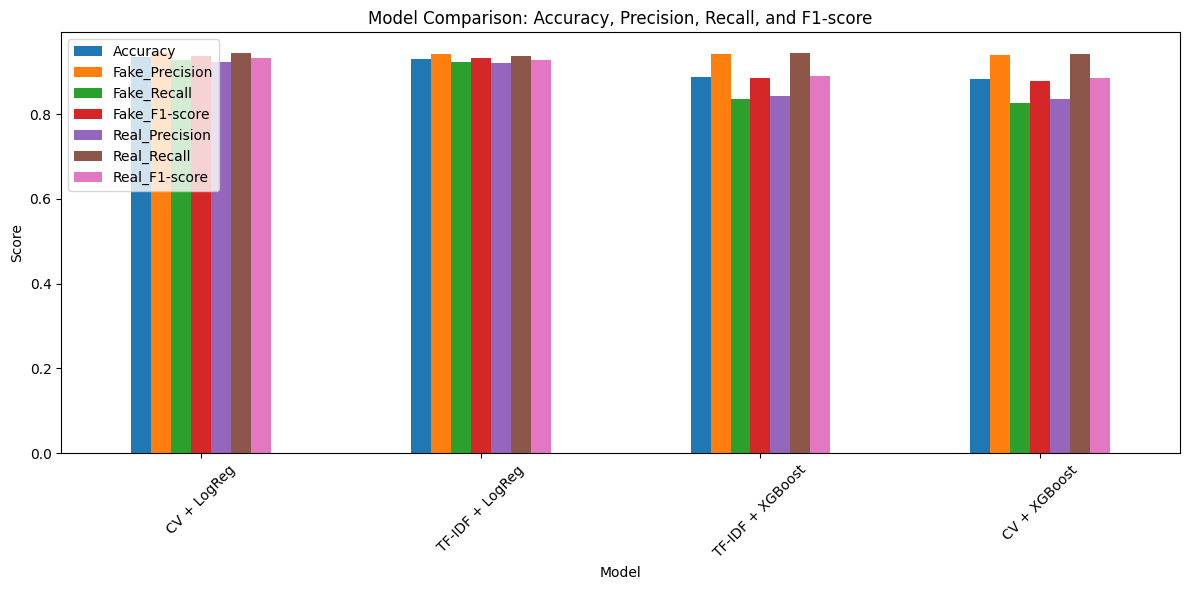

In [31]:
from sklearn.metrics import classification_report
import pandas as pd

# Assuming y_test contains integer labels (0 and 1)
# Map integer labels to string labels for classification report
target_names = ['fake', 'real']

# Generate classification reports with target_names
report1 = classification_report(y_test, pred1, target_names=target_names, output_dict=True, zero_division=0)
report2 = classification_report(y_test, pred2, target_names=target_names, output_dict=True, zero_division=0)
report3 = classification_report(y_test, pred3, target_names=target_names, output_dict=True, zero_division=0)
report4 = classification_report(y_test, pred4, target_names=target_names, output_dict=True, zero_division=0)

# Extract metrics for the table
model_comparison = {
    'Model': ['CV + LogReg', 'TF-IDF + LogReg', 'CV + XGBoost', 'TF-IDF + XGBoost'],
    'Accuracy': [accuracy_score(y_test, pred1), accuracy_score(y_test, pred2), accuracy_score(y_test, pred3), accuracy_score(y_test, pred4)],
    'Fake_Precision': [report1['fake']['precision'], report2['fake']['precision'], report3['fake']['precision'], report4['fake']['precision']],
    'Fake_Recall': [report1['fake']['recall'], report2['fake']['recall'], report3['fake']['recall'], report4['fake']['recall']],
    'Fake_F1-score': [report1['fake']['f1-score'], report2['fake']['f1-score'], report3['fake']['f1-score'], report4['fake']['f1-score']],
    'Real_Precision': [report1['real']['precision'], report2['real']['precision'], report3['real']['precision'], report4['real']['precision']],
    'Real_Recall': [report1['real']['recall'], report2['real']['recall'], report3['real']['recall'], report4['real']['recall']],
    'Real_F1-score': [report1['real']['f1-score'], report2['real']['f1-score'], report3['real']['f1-score'], report4['real']['f1-score']],
}

comparison_df = pd.DataFrame(model_comparison)
comparison_df_sorted = comparison_df.sort_values(by='Accuracy', ascending=False)
display(comparison_df_sorted)

#Display the comparison DataFrame accuracy, precision, recall, and F1-score for each model in a graphical format
comparison_df_sorted.plot(x='Model', kind='bar', figsize=(12, 6), rot=45)
plt.title('Model Comparison: Accuracy, Precision, Recall, and F1-score')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



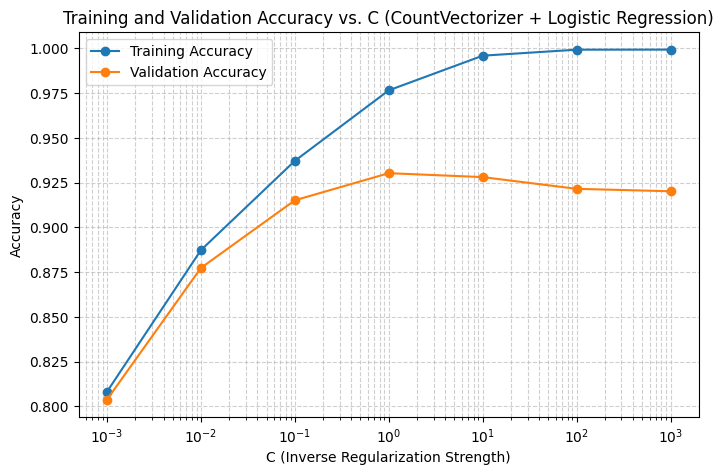

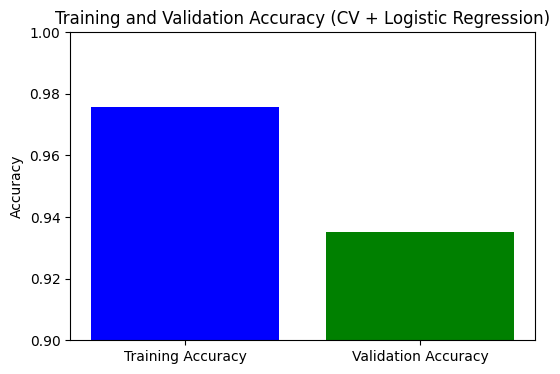

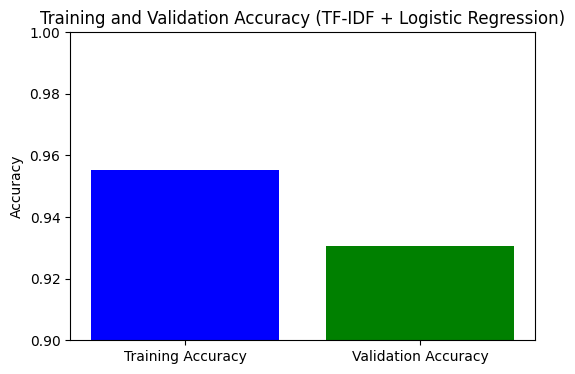

In [34]:
# For CountVectorizer + Logistic Regression (GridSearchCV example with LogisticRegression)
from sklearn.model_selection import GridSearchCV

# Example: Hyperparameter tuning for LogisticRegression (C parameter)
param_grid = {'C': np.logspace(-3, 3, 7)}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(X_train_cv, y_train)

results = grid.cv_results_
train_scores = results['mean_train_score']
val_scores = results['mean_test_score']
params = results['params']

C_values = [p['C'] for p in params]

plt.figure(figsize=(8, 5))
plt.plot(C_values, train_scores, label='Training Accuracy', marker='o')
plt.plot(C_values, val_scores, label='Validation Accuracy', marker='o')
plt.xscale('log')
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. C (CountVectorizer + Logistic Regression)')
plt.legend()
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.show()

# For CountVectorizer + Logistic Regression
# Calculate training accuracy
y_train_pred_CVLR = LG.predict(X_train_cv)
train_acc_CVLR = accuracy_score(y_train, y_train_pred_CVLR)

# Calculate validation accuracy (already have this as acc_rf)
val_acc_CVLR = accuracy_score(y_test, pred1)

plt.figure(figsize=(6, 4))
plt.bar(['Training Accuracy', 'Validation Accuracy'], [train_acc_CVLR, val_acc_CVLR], color=['blue', 'green'])
plt.ylim(0.9, 1.0)
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (CV + Logistic Regression)')
plt.show()

# For TF-IDF + Logistic Regression
# Calculate training accuracy
y_train_pred_TFIDFLR = LG2.predict(X_train_tfidf)
train_acc_TFIDFLR = accuracy_score(y_train, y_train_pred_TFIDFLR)

# Calculate validation accuracy (already have this as accuracy_score(y_test, pred1_tf))
val_acc_nb_tf = accuracy_score(y_test, pred2)

plt.figure(figsize=(6, 4))
plt.bar(['Training Accuracy', 'Validation Accuracy'], [train_acc_TFIDFLR, val_acc_nb_tf], color=['blue', 'green'])
plt.ylim(0.9, 1.0)
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (TF-IDF + Logistic Regression)')
plt.show()

C:\Users\karel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:50:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\karel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:50:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\karel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:50:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } 

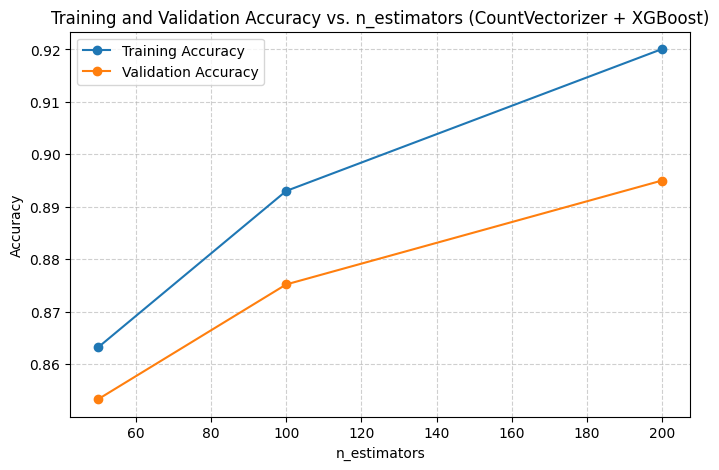

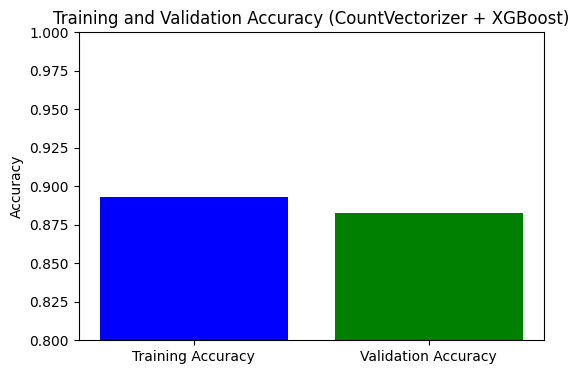

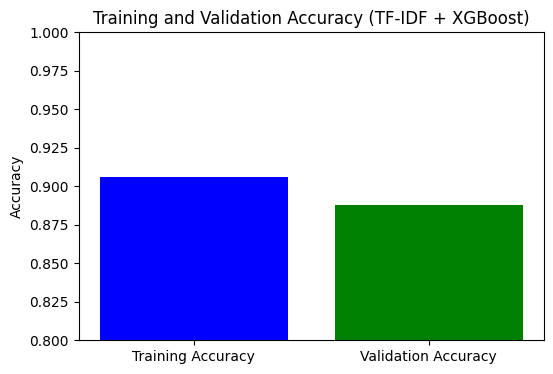

C:\Users\karel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:50:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\karel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:50:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\karel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:50:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } 

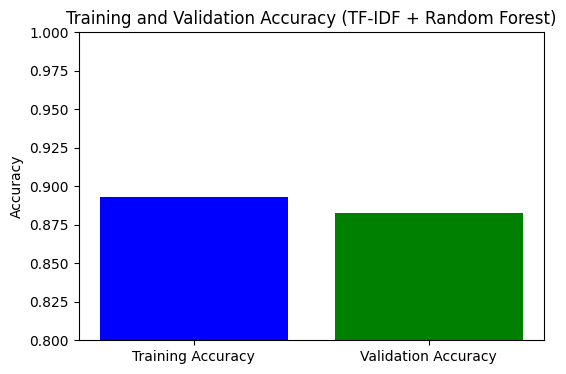

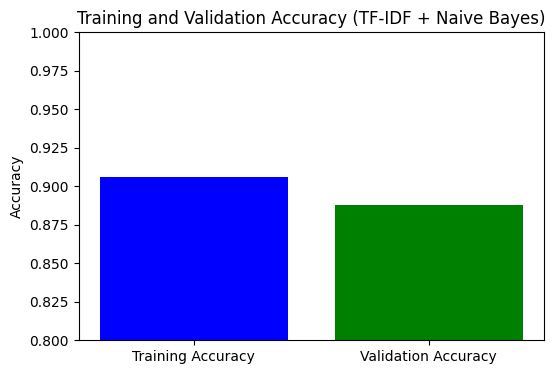

In [36]:
from sklearn.model_selection import GridSearchCV

# For CountVectorizer + XGBoost
param_grid = {'C': np.logspace(-3, 3, 7)}
# Use GridSearchCV for XGBoost (CountVectorizer features)

# Example: Hyperparameter tuning for XGBoost (n_estimators parameter)
param_grid = {'n_estimators': [50, 100, 200]}
grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(X_train_cv, y_train)

results = grid.cv_results_
train_scores = results['mean_train_score']
val_scores = results['mean_test_score']
params = results['params']

n_estimators_values = [p['n_estimators'] for p in params]

plt.figure(figsize=(8, 5))
plt.plot(n_estimators_values, train_scores, label='Training Accuracy', marker='o')
plt.plot(n_estimators_values, val_scores, label='Validation Accuracy', marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. n_estimators (CountVectorizer + XGBoost)')
plt.legend()
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.show()

# Calculate training accuracy
y_train_pred_CVXGB = XGBmodel1.predict(X_train_cv)
train_acc_CVXGB = accuracy_score(y_train, y_train_pred_CVXGB)

# Calculate validation accuracy (already have this as acc_rf)
val_acc_CVXGB = accuracy_score(y_test, pred3)

plt.figure(figsize=(6, 4))
plt.bar(['Training Accuracy', 'Validation Accuracy'], [train_acc_CVXGB, val_acc_CVXGB], color=['blue', 'green'])
plt.ylim(0.8, 1.0)
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (CountVectorizer + XGBoost)')
plt.show()

# For TF-IDF + XGBoost
# Calculate training accuracy
y_train_pred_TFIDFXGB = XGBmodel2.predict(X_train_tfidf)
train_acc_TFIDFXGB = accuracy_score(y_train, y_train_pred_TFIDFXGB)

# Calculate validation accuracy (already have this as accuracy_score(y_test, pred4))
val_acc_TFIDFXGB = accuracy_score(y_test, pred4)

plt.figure(figsize=(6, 4))
plt.bar(['Training Accuracy', 'Validation Accuracy'], [train_acc_TFIDFXGB, val_acc_TFIDFXGB], color=['blue', 'green'])
plt.ylim(0.8, 1.0)
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (TF-IDF + XGBoost)')
plt.show()
grid.fit(X_train_cv, y_train)

results = grid.cv_results_
train_scores = results['mean_train_score']
val_scores = results['mean_test_score']
params = results['params']

# C_values = [p['C'] for p in params]  # Not needed for XGBoost param_grid


# Calculate training accuracy
y_train_pred_CVXGB = XGBmodel1.predict(X_train_cv)
train_acc_CVXGB = accuracy_score(y_train, y_train_pred_CVXGB)

# Calculate validation accuracy (already have this as acc_rf)
val_acc_CVXGB = accuracy_score(y_test, pred3)

plt.figure(figsize=(6, 4))
plt.bar(['Training Accuracy', 'Validation Accuracy'], [train_acc_CVXGB, val_acc_CVXGB], color=['blue', 'green'])
plt.ylim(0.8, 1.0)
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (TF-IDF + Random Forest)')
plt.show()

# For TF-IDF + Logistic XGBoost
# Calculate training accuracy
y_train_pred_TFIDFXGB = XGBmodel2.predict(X_train_tfidf)
train_acc_TFIDFXGB = accuracy_score(y_train, y_train_pred_TFIDFXGB)

# Calculate validation accuracy (already have this as accuracy_score(y_test, pred1_tf))
val_acc_TFIDFXGB = accuracy_score(y_test, pred4)

plt.figure(figsize=(6, 4))
plt.bar(['Training Accuracy', 'Validation Accuracy'], [train_acc_TFIDFXGB, val_acc_TFIDFXGB], color=['blue', 'green'])
plt.ylim(0.8, 1.0)
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (TF-IDF + Naive Bayes)')
plt.show()

# Conclusion: 
# In this notebook, we have iterated on our previous version of our fake news classifier model. In this iteration, we trained two different classification methods: Logistic Regression and XGBoost. 
# Logistic Regression with CountVectorizer gave the best results: an accuracy score of 0.9352. The worst performing combination was XGBoost with TFIDF: accuracy score of 0.8824. 
# We can theorize why that is, our suspicion is that the simplicity of Logistic Regression prevents overfitting due to its built-in regularization. Further, the size of the dataset fits Logistic Regression well (+/- 40k samples). There are also text specific factors at play: fake news is often characterized by specific vocabulary, writing styles or linguistig patterns. A simpler model like LogReg is better at capturing these than a more complex one like XGBoost. 